# Introduction
In this notebook, we will attempt to explore the [Covid19 Tweets Dataset](https://www.kaggle.com/sohelranaccselab/covid19coronavirus-tweets-text-classification). We will try to answer some business questions and peek at some trends in an enhanced EDA and visualization environment. Later, we will develop machine learning model.

Here are the steps that we will take:
1. Loading dataset and exploring its core statistics.
2. Perform EDA on non-tweeted features such as date, location etc.
3. Perform EDA on the tweets before cleaning.
4. Clean the text.
5. Perform EDA on the cleaned tweets.
6. List all the business questions possible.
7. Model building.
8. Final thoughts

Note: Visualization will take place simultaneously in some of the above steps.


In [1]:
# Importing all the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re
from typing import List
import nltk
import inflect, unicodedata

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### 1. Loading dataset and exploring its core statistics.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Covid19 Tweets Sentiment/Corona_NLP_train.csv', engine='python')

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
print(f'Rows = {df.shape[0]}\nColumns = {df.shape[1]}')

Rows = 41157
Columns = 6


In [6]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
df['Location'] = df['Location'].fillna('Unknown')
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [8]:
unique_usernames = len(df['UserName'].unique())
unique_locations = len(df['Location'].unique())
unique_tweetat = len(df['TweetAt'].unique())
unique_sentiments = len(df['Sentiment'].unique())
print(f'Total usernames = {unique_usernames}\nTotal locations = {unique_locations}\nTotal tweets dates = {unique_tweetat}\nTotal sentiments classes = {unique_sentiments}')

Total usernames = 41157
Total locations = 12220
Total tweets dates = 30
Total sentiments classes = 5


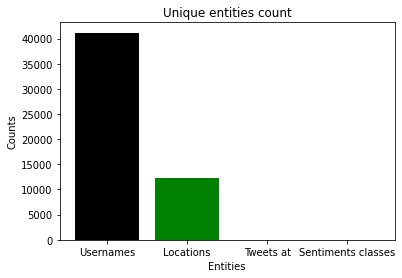

In [9]:
x = ['Usernames', 'Locations', 'Tweets at', 'Sentiments classes']
y = [unique_usernames, unique_locations, unique_tweetat, unique_sentiments]
plt.bar(x, y, color=['black', 'green', 'red', 'blue'])
plt.title('Unique entities count')
plt.xlabel('Entities')
plt.ylabel('Counts')
plt.show()

### 2. EDA on non-tweeted features

In [10]:
sentiment_value_counts = df['Sentiment'].value_counts()
sentiments = ['Positive', 'Negative', 'Neutral', 'Extremely +ve', 'Extremely -ve']
sentiment_value_counts

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

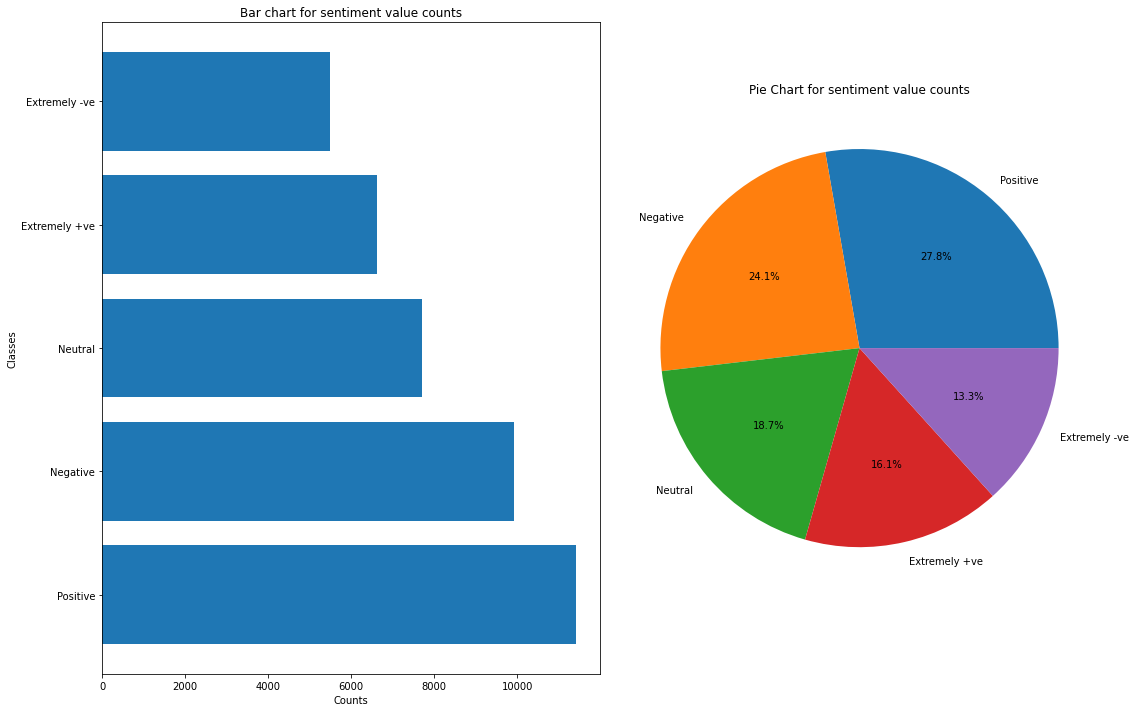

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, squeeze=True, figsize=(16,10))
ax1.barh(sentiments, sentiment_value_counts.values)
ax1.set_title('Bar chart for sentiment value counts')
ax1.set_xlabel('Counts')
ax1.set_ylabel('Classes')

ax2.pie(sentiment_value_counts.values, labels=sentiments, autopct='%1.1f%%')
ax2.set_title('Pie Chart for sentiment value counts')

fig.tight_layout()
fig.show()

In [12]:
top30_locations = df['Location'].value_counts(sort=True, ascending=False).nlargest(30)
top30_locations[:10]

Unknown            8593
London              540
United States       528
London, England     520
New York, NY        395
Washington, DC      373
United Kingdom      337
Los Angeles, CA     281
India               268
UK                  232
Name: Location, dtype: int64

In [13]:
top30_locations = top30_locations[1:]

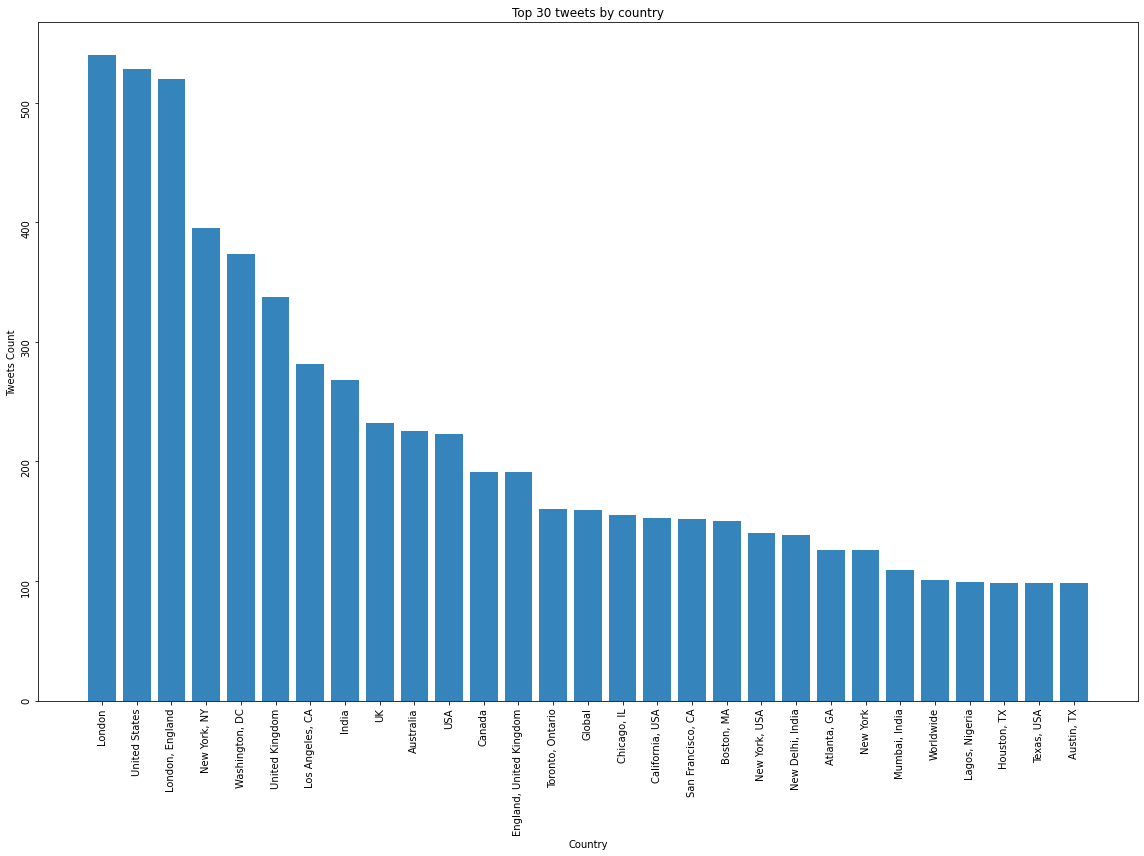

In [14]:
fig, ax = plt.subplots(1,1, squeeze=True, figsize=(16,12))
ax.bar(top30_locations.keys(), top30_locations.values, alpha=0.9)
ax.set_title('Top 30 tweets by country')
ax.set_xlabel('Country')
ax.set_ylabel('Tweets Count')
ax.tick_params(labelrotation=90)
fig.tight_layout()
fig.show()

We can clearly see that the total amount of tweets were done by United Kingdom if we group by country. City-wise, it is London.

In [15]:
top30_dates = df['TweetAt'].value_counts(sort=True, ascending=False).nlargest(30)
top30_dates[:10]

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
Name: TweetAt, dtype: int64

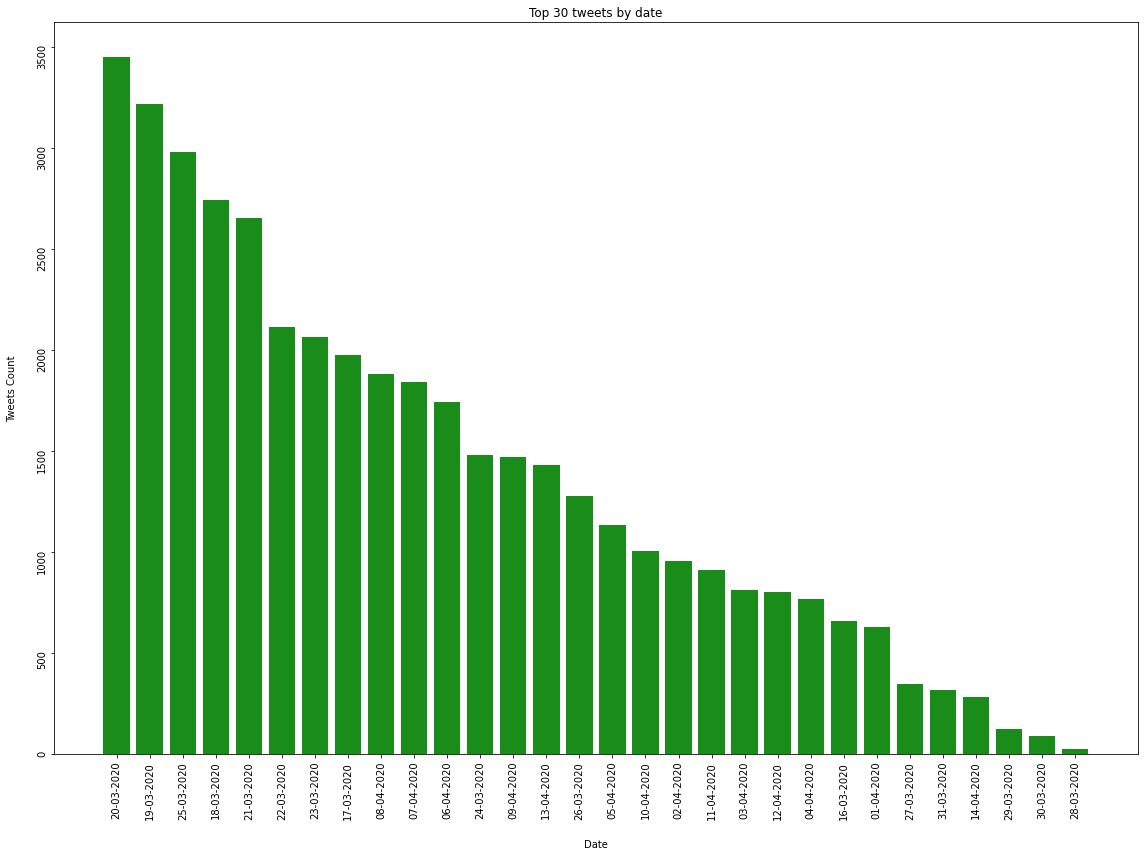

In [16]:
fig, ax = plt.subplots(1,1, squeeze=True, figsize=(16,12))
ax.bar(top30_dates.keys(), top30_dates.values, alpha=0.9, color=['green'])
ax.set_title('Top 30 tweets by date')
ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Tweets Count', labelpad=20)
ax.tick_params(labelrotation=90)
fig.tight_layout()
fig.show()

The majority of tweets were done on March 20, 2020. This was the peak time of countries opting for lockdown due to the pandemic.

In [17]:
top10_users = df['UserName'].value_counts(sort=True, ascending=False).nlargest(10)
top10_users[:10]

4094     1
25862    1
30052    1
19811    1
17762    1
23905    1
21856    1
44383    1
42334    1
36187    1
Name: UserName, dtype: int64

It looks like no user tweeted more than once about covid19. It could be the case that some might have used different accounts.

### 3. EDA on the tweets before cleaning.

In [18]:
def count_words(text):
  return len(text.split())

df['Num_Words'] = df['OriginalTweet'].apply(count_words)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Num_Words
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,38
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,14
3,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,Positive,42
4,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,40


In [19]:
df_neutral = df[df['Sentiment']=='Neutral']
df_positive = df[df['Sentiment']=='Positive']
df_negative = df[df['Sentiment']=='Negative']
df_x_negative = df[df['Sentiment'] == 'Extremely Negative']
df_x_posititve = df[df['Sentiment'] == 'Extremely Positive']

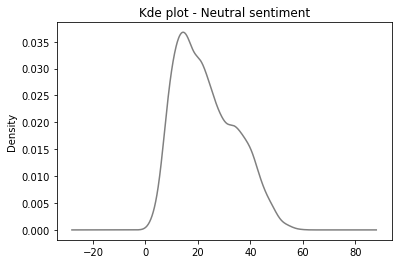

In [20]:
df_neutral['Num_Words'].plot(kind='kde', title='Kde plot - Neutral sentiment', color='grey')

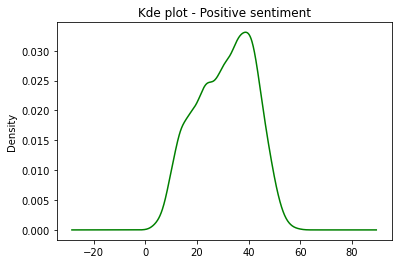

In [21]:
df_positive['Num_Words'].plot(kind='kde', title='Kde plot - Positive sentiment', color='green')

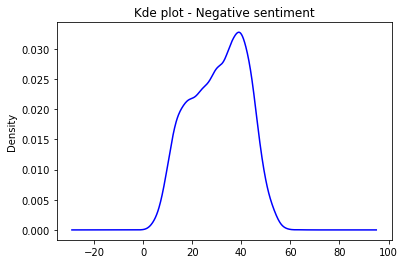

In [22]:
df_negative['Num_Words'].plot(kind='kde', title='Kde plot - Negative sentiment', color='blue')

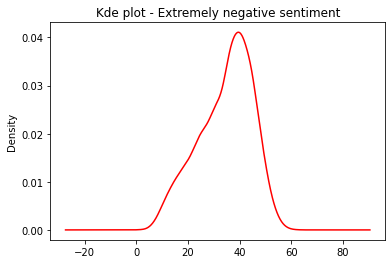

In [23]:
df_x_negative['Num_Words'].plot(kind='kde', title='Kde plot - Extremely negative sentiment', color='red')

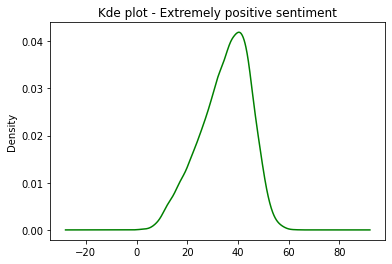

In [24]:
df_x_posititve['Num_Words'].plot(kind='kde', title='Kde plot - Extremely positive sentiment', color='green')

It looks like extremely +ve and -ve tweets contain more lengthy texts as compared to the other three classes.

### 4. Cleaning the text.

In [25]:
def to_lowercase(text):
  return text.lower()

def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
  PUNCT_TO_REMOVE = punctuation
  PUNCT_TO_REMOVE += '’'
  clean_txt = ''.join([ch for ch in text if ch not in PUNCT_TO_REMOVE])
  return clean_txt

def tokenize_text(text):
  return word_tokenize(text)

def remove_stop_words(text):
  STOP_WORDS = stopwords.words('english')
  new_words = []
  for word in text:
    if word not in STOP_WORDS:
      new_words.append(word)
  return new_words

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  lem_list = [lemmatizer.lemmatize(word) for word in text]
  return lem_list

def clean_text(text):
  text = to_lowercase(text)
  text = remove_urls(text)
  text = remove_emoji(text)
  text = remove_punctuation(text)
  text = tokenize_text(text)
  text = remove_stop_words(text)
  text = remove_non_ascii(text)
  text = lemmatize_text(text)
  return text

In [26]:
df_tweets = df[['OriginalTweet', 'Sentiment']]
df_tweets.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_tweets['CleanTweet'] = df['OriginalTweet'].apply(lambda x: clean_text(x))

In [28]:
df_tweets.head()

,OriginalTweet,Sentiment,CleanTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[menyrbie, philgahan, chrisitv]"
1,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, neighbour, family, exchange, ph..."
2,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, woolworth, give, elde..."
3,My food stock is not the only one which is emp...,Positive,"[food, stock, one, empty, please, dont, panic,..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im..."


In [29]:
df_tweets.loc[159]['CleanTweet']

['79',
 'nearly',
 '80',
 'year',
 'old',
 'nana',
 'hasnt',
 'stock',
 'piled',
 'food',
 'toilet',
 'roll',
 'butshe',
 'stocked',
 'cupboard',
 'two',
 'full',
 'tub',
 'horlicks',
 'priority',
 'coronavirus']

In [30]:
df_tweets = df_tweets[['Sentiment', 'CleanTweet']]

In [31]:
df_tweets.head()

,Sentiment,CleanTweet
0,Neutral,"[menyrbie, philgahan, chrisitv]"
1,Positive,"[advice, talk, neighbour, family, exchange, ph..."
2,Positive,"[coronavirus, australia, woolworth, give, elde..."
3,Positive,"[food, stock, one, empty, please, dont, panic,..."
4,Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im..."


We have cleaned the tweets. Now, we can perform EDA on them.

### 5. EDA on the cleaned tweets.

Lets explore top words in the tweets.

In [ ]:
top_words_overall = Counter([item for sublist in df_tweets['CleanTweet'] for item in sublist])

In [ ]:
df_top_words_overall = pd.DataFrame(top_words_overall.most_common(30), columns=['Word', 'Count'])

In [ ]:
df_top_words_overall.head()

,Word,Count
0,coronavirus,18029
1,covid19,16850
2,price,8940
3,store,8157
4,supermarket,7732


In [ ]:
fig = px.bar(df_top_words_overall, x="Count", y="Word", title='Top 30 common words', orientation='h', 
             width=700, height=700,color='Word')
fig.show()

Let's explore top words in each class of sentiment.

In [ ]:
def get_df_by_sentiment_type(df, class_type):
  return df_tweets[df['Sentiment'] == class_type]

df_positive_only = get_df_by_sentiment_type(df_tweets, 'Positive')
df_negative_only = get_df_by_sentiment_type(df_tweets, 'Negative')
df_neutral_only = get_df_by_sentiment_type(df_tweets, 'Neutral')
df_x_pos = get_df_by_sentiment_type(df_tweets, 'Extremely Positive')
df_x_neg = get_df_by_sentiment_type(df_tweets, 'Extremely Negative')

In [ ]:
def show_words_plot(df, title_of_the_chart):
  top_words = Counter([item for sublist in df['CleanTweet'] for item in sublist])
  df_top_words = pd.DataFrame(top_words.most_common(30), columns=['Word', 'Count'])

  fig = px.bar(df_top_words, x="Count", y="Word", title=title_of_the_chart, orientation='h', 
             width=700, height=700,color='Word')
  fig.show()

In [ ]:
show_words_plot(df_positive_only, 'Top 30 common words in positive tweets')

In [ ]:
show_words_plot(df_negative_only, 'Top 30 common words in negative tweets')

In [ ]:
show_words_plot(df_neutral_only, 'Top 30 common words in neutral tweets')

In [ ]:
show_words_plot(df_x_pos, 'Top 30 common words in extremely positive tweets')

In [ ]:
show_words_plot(df_x_neg, 'Top 30 common words in extremely negative tweets')

### 6. Business questions and answers.

1. How many total sentiments were recorded?
   
   A1. There are 5 total sentiments.

2. Which country tweeted the most?

   A2. United Kingdom tweeted the most. 

3. What was the tweet trend (date-wise)?

   A3. The trend decreased after 20th March 2020.

4. On which date were the tweets count maximum?

   A4. March 20, 2020

5. Which user was engaged the most in tweets?
   
   A5. All user count was 1. So all of them were unique and maximum.

6. What is the relationship between tweets length in all classes?

   A6. For info, check KDE plots.

7. What are the most frequent words in all the tweets?

   A7. Check the chart above.

8. What are the most frequent words in each sentiment class?

   A8. Check the charts above.

## 7. Model building.

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pickle

In [33]:
# Taking only 2 classes i.e. +ve and -ve sentiments.
df_tweets_3 = df_tweets[df_tweets['Sentiment'] != 'Extremely Positive']

In [34]:
df_tweets_3 = df_tweets_3[df_tweets_3['Sentiment'] != 'Extremely Negative']

In [35]:
df_tweets_3 = df_tweets_3[df_tweets_3['Sentiment'] != 'Neutral']

In [36]:
df_tweets_3.head()

,Sentiment,CleanTweet
1,Positive,"[advice, talk, neighbour, family, exchange, ph..."
2,Positive,"[coronavirus, australia, woolworth, give, elde..."
3,Positive,"[food, stock, one, empty, please, dont, panic,..."
5,Positive,"[news, region, first, confirmed, covid19, case..."
6,Positive,"[cashier, grocery, store, sharing, insight, co..."


In [37]:
df_tweets_3['Sentiment'].value_counts()

Positive    11422
Negative     9917
Name: Sentiment, dtype: int64

In [38]:
label_encoder = LabelEncoder()
y_labels = df_tweets_3['Sentiment'].values
y_labels = label_encoder.fit_transform(y_labels)
y_labels[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [39]:
df_tweets_3['JoinedTweet'] = df_tweets_3['CleanTweet'].apply(lambda x: ' '.join(ch for ch in x))

In [40]:
x_tweets = df_tweets_3['JoinedTweet'].values
x_tweets[:4]

array(['advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order',
       'coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid19 outbreak',
       'food stock one empty please dont panic enough food everyone take need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'news region first confirmed covid19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good timdodson report'],
      dtype=object)

In [41]:
tf_idf = TfidfVectorizer()
x_tweets = tf_idf.fit_transform(x_tweets)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x_tweets, y_labels, test_size=0.2)
print(f'X_train shape = {X_train.shape}\nX_test shape = {X_test.shape}')
print(f'y_train shape = {y_train.shape}\ny_test shape = {y_test.shape}')

X_train shape = (17071, 36877)
X_test shape = (4268, 36877)
y_train shape = (17071,)
y_test shape = (4268,)


In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7284442361761949


In [ ]:
svm = LinearSVC(penalty='l2', C=1.5)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8006091846298032


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7696813495782568


In [ ]:
model_params = {
    'LinearSvc': {
        'model': LinearSVC(),
        'params': {
            'penalty': ['l2'],
            'loss': ['squared_hinge'],
            'C': [1.0, 1.5, 2.0, 2.5]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'verbose': [1,2,3],
            'solver': ['lbfgs', 'sag', 'saga']
        }
    }
}

In [ ]:
scores_of_models = []
for model_name, p in model_params.items():
    tuner = GridSearchCV(p['model'], p['params'], cv=5, return_train_score=False)
    tuner.fit(x_tweets, y_labels)
    scores_of_models.append({
        'Model': model_name,
        'Best_Score': tuner.best_score_,
        'Best_Params': tuner.best_params_
    })

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jo

convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 1 seconds
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 1 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
convergence after 23 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 22 epochs took 0 seconds
convergence after 22 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [ ]:
score_df = pd.DataFrame(scores_of_models, columns=['Model','Best_Score','Best_Params'])
score_df

,Model,Best_Score,Best_Params
0,LinearSvc,0.793711,"{'C': 1.0, 'loss': 'squared_hinge', 'penalty':..."
1,LogisticRegression,0.766015,"{'solver': 'sag', 'verbose': 1}"


Even afer hyperparameter tuning, we were able to get a score close to 80% (LinearSVC). Hence, we will save this model.

In [ ]:
pickle.dump(svm, open('/content/drive/MyDrive/linearSVC.pkl', 'wb'))

In [43]:
pickle.dump(tf_idf, open('/content/drive/MyDrive/tf_idf.pkl', 'wb'))

Let us try our model on a custom tweet.

In [49]:
txt = 'covid is very good'
txt = clean_text(txt)
txt = ' '.join(ch for ch in txt)
txt

'covid good'

In [54]:
tfidf = pickle.load(open('/content/drive/MyDrive/tf_idf.pkl', 'rb'))
vec = tfidf.transform([txt])

In [55]:
svcmodel = pickle.load(open('/content/drive/MyDrive/linearSVC.pkl', 'rb'))

In [56]:
predictions = svcmodel.predict(vec)

In [57]:
predictions

array([1])

We can see that the tweet was positive and it gave correct results. Of course, the results will be 80% accurate if tweet is more complex.

### 8. Final thoughts.
We explored the data and answered many business questions. Furthermore, we built the model using machine learning and saved it. 

One thing that can be done is that we can clean the data more and use hyparameter tuning to increase our accuracy. 

We are finished here.